# Examination of Results from the Calibration / Affirmation set

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
import pandas as pd
import gzbuilder_analysis.parsing as pg
import gzbuilder_analysis.aggregation as ag
from tqdm import tqdm
import json
from PIL import Image
from IPython.display import Markdown

In [3]:
affirmation_set_id = 80112

In [4]:
classifications = pd.read_csv('lib/galaxy-builder-classifications.csv', index_col=0)
subjects = pd.read_csv('lib/galaxy-builder-subjects.csv', index_col=0)
fitting_metadata = pd.read_pickle('lib/fitting_metadata.pkl')

In [5]:
metadata = subjects.metadata.apply(json.loads).apply(pd.Series)

Read in the required files:

In [6]:
base_models = pd.read_pickle(
    'affirmation_subjects_results/base_models.pkl.gz'
)
agg_results = pd.read_pickle(
    'affirmation_subjects_results/agg_results.pkl.gz'
)
diffs = pd.read_pickle(
    'affirmation_subjects_results/affirmation_metadata.pkl.gz'
)

In [7]:
' '.join(map(str, list(base_models.index)))

'20902055 21686576 21686588 20902038 21686502 21686529 20902067 20902006 20902035'

Or recalculate them by uncommenting here

In [8]:
# base_models = {}
# for f in [i for i in os.listdir('affirmation_set_models') if re.match(r'.*?\.pkl', i)]:
#     dump = pd.read_pickle(os.path.join('affirmation_set_models', f))
#     base_models[dump['idx']] = dump
# base_models = pd.DataFrame(base_models).T.drop(columns='idx')

In [10]:
# base_models

In [11]:
index_map = pd.DataFrame(dict(name={k: base_models.name[k] for k in base_models.index}), columns=('name', 'subject_id')).sort_index()

In [12]:
affirmation_subjects = subjects.query('subject_set_id == @affirmation_set_id').index.values

If we need to update any clustering parameters, do it here:

In [11]:
# from gzbuilder_analysis.config import COMPONENT_CLUSTERING_PARAMS
# from copy import deepcopy

# clustering_params = deepcopy(COMPONENT_CLUSTERING_PARAMS)

In [12]:
# display(clustering_params)

In [13]:
# agg_results = pd.Series([], dtype=object)
# diffs = pd.Series([], dtype=object)
# with tqdm(affirmation_subjects) as bar:
#     for subject_id in bar:
#         base_subject_id = int(metadata.loc[subject_id]['#subject_reference'])
#         im = np.array(Image.open('lib/subject_data/{}/image.png'.format(base_subject_id)))[::-1]
#         fm = fitting_metadata.loc[base_subject_id]

#         base_model = base_models.loc[base_subject_id]
#         with open('affirmation_subjects/difference_{}.json'.format(base_model['name'])) as f:
#             diff = json.load(f)
#         target = np.array(diff['imageData'])
#         # take the first 30 classifications recieved for this galaxy
#         c = (classifications
#             .query('subject_ids == {}'.format(subject_id))
#             .sort_values(by='created_at')
#             .head(30)
#         )
#         zoo_models = c.apply(
#             pg.parse_classification,
#             axis=1,
#             image_size=np.array(im.shape),
#             size_diff=diff['width'] / diff['imageWidth'],
#             ignore_scale=True  # ignore scale slider when aggregating
#         )
#         scaled_models = zoo_models.apply(
#             pg.scale_model,
#             args=(diff['width'] / diff['imageWidth'],),
#         )
#         # we don't worry about reprojecting or rotating models here as we know 
#         # things are correct
#         sanitized_models = scaled_models.apply(pg.sanitize_model)
#         aggregation_result = ag.AggregationResult(sanitized_models, target, clustering_params=clustering_params)
        
#         mask = np.array(diff['mask'])
#         diffs.loc[base_subject_id] = pd.Series(dict(
#             galaxy_data=np.ma.masked_array(np.array(diff['imageData']), mask),
#             sigma_image=np.ma.masked_array(fm['sigma_image'], mask),
#             psf=fm['psf'],
#             multiplier=1,
#         ), dtype=object)
#         index_map.loc[base_subject_id, 'subject_id'] = subject_id
# #         agg_results.loc[base_subject_id] = aggregation_result

In [14]:
# base_models.to_pickle('affirmation_subjects_results/base_models.pkl.gz')
# agg_results.to_pickle('affirmation_subjects_results/agg_results.pkl.gz')
# diffs.to_pickle('affirmation_subjects_results/affirmation_metadata.pkl.gz')

Do people know when to draw components?

In [13]:
n_comp_cls = pd.DataFrame({
    k: agg_results.apply(lambda a: a.input_models.apply(lambda b: bool(b[k])).sum())
    for k in ('disk', 'bulge', 'bar')
})
n_comp_cls.index = index_map.name[n_comp_cls.index]
n_comp_cls.sort_values(by='bar').astype(str) + ' / 30'

,disk,bulge,bar
name,,,
disk_model,28 / 30,12 / 30,4 / 30
disk_sp_model,27 / 30,15 / 30,5 / 30
disk_bulge_model2,28 / 30,23 / 30,5 / 30
disk_bulge_model,24 / 30,19 / 30,5 / 30
disk_bulge_sp_model,28 / 30,20 / 30,7 / 30
disk_bulge_bar_model,27 / 30,20 / 30,13 / 30
disk_bar_sp_model2,30 / 30,24 / 30,17 / 30
disk_bulge_bar_sp_model,27 / 30,23 / 30,20 / 30
disk_bar_sp_model,28 / 30,19 / 30,22 / 30


People consistently made use of disks, and four galaxies containing bars recieved more bar classifications than the galaxies without, but the consensus was not very high!

In [15]:
base_params = base_models['model'].apply(
    lambda a: pd.Series(a).apply(pd.Series).T.unstack().dropna()
).sort_index()

recovered_params = agg_results.apply(lambda a: a.params).sort_index()

In [16]:
base_has_comp = pd.concat([
    *[base_params[k]['I'].notna().rename(k) for k in ('disk', 'bulge', 'bar')],
    *[base_params['spiral'][f'I.{i}'].notna().rename(f'spiral.{i}') for i in (int(i.group(1)) for i in (re.match(r'I.([0-9]+)', r) for r in base_params['spiral'].columns) if i)]
], axis=1)

__empty_df = pd.DataFrame([], dtype=float)
agg_has_comp = pd.concat([
    *[recovered_params[k]['I'].notna().rename(k) for k in ('disk', 'bulge', 'bar')],
    *[
        recovered_params['spiral']['I.{}'.format(int(i.group(1)))].notna().rename('spiral.{}'.format(int(i.group(1))))
        for i in (
            re.match(r'I.([0-9]+)', r)
            for r in recovered_params.get('spiral', __empty_df).columns
        )
        if i is not None
    ]
], axis=1)

In [17]:
base_has_comp2 = base_has_comp.copy()
base_has_comp2.index = index_map.name[base_has_comp2.index]
agg_has_comp2 = agg_has_comp.copy()
agg_has_comp2.index = index_map.name[agg_has_comp2.index]

def color_false_red(val):
    color = 'green' if val == '✔️' else 'red'
    return 'color: %s' % color

display(Markdown('### Did we recover the component?:'))
df = (base_has_comp2.astype(int) - agg_has_comp2.astype(int)).astype(object).fillna(0)
df[~(base_has_comp2 | agg_has_comp2)] = np.nan
df.index = pd.MultiIndex.from_arrays([index_map.name, index_map.index.rename('base_subject_id')])
df.replace(np.nan, '').replace(1, 'Type 2').replace(-1, 'Type 1').replace(0, '✔️').style.applymap(color_false_red)

### Did we recover the component?:

,,disk,bulge,bar,spiral.0,spiral.1,spiral.2
name,base_subject_id,,,,,,
disk_bar_sp_model,20902006,✔️,Type 1,✔️,✔️,✔️,
disk_bulge_bar_model,20902035,✔️,✔️,Type 2,,,
disk_bulge_model2,20902038,✔️,✔️,,,,
disk_sp_model,20902055,✔️,,,✔️,✔️,✔️
disk_bulge_sp_model,20902067,✔️,✔️,,✔️,✔️,
disk_model,21686502,✔️,,,,,
disk_bulge_bar_sp_model,21686529,✔️,✔️,✔️,✔️,✔️,
disk_bar_sp_model2,21686576,✔️,Type 1,✔️,✔️,✔️,
disk_bulge_model,21686588,✔️,✔️,,,,


In [18]:
from gzbuilder_analysis.aggregation.spirals import get_drawn_arms
from astropy.visualization import AsinhStretch
from descartes import PolygonPatch

Plot the models we recieved:

In [19]:
os.makedirs('affirmation_subjects_results/classifications', exist_ok=True)
with tqdm(base_models.index) as bar:
    for subject_id in bar:
        geoms = agg_results[subject_id].input_models.apply(ag.get_geoms).apply(pd.Series)
        drawn_arms = agg_results[subject_id].input_models
        f, ax_ = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(8, 9), dpi=100)
        ax = ax_.ravel()
        plt.suptitle(index_map.name[subject_id].replace('_', ' ').replace('sp', 'spiral').capitalize())
        im = np.array(diffs.loc[subject_id].galaxy_data)
        [a.axis('off') for a in ax];
        [a.imshow(AsinhStretch()(im), cmap='gray_r') for a in ax];

        for i, k in enumerate(('disk', 'bulge', 'bar')):
            for _, g in geoms[k].iteritems():
                if g is not None:
                    ax[i].add_patch(PolygonPatch(g, ec='C{}'.format(i), fc='none', alpha=0.6))

        for arm in get_drawn_arms(agg_results[subject_id].input_models):
            ax[3].plot(*arm.T, c='r', alpha=0.4)
        plt.tight_layout()
        plt.xlim(0, im.shape[1])
        plt.ylim(0, im.shape[0])
        plt.savefig('affirmation_subjects_results/classifications/{}.png'.format(index_map.name[subject_id]), bbox_inches='tight')
        plt.close()

100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


We have performed tuning separately, let's see how models stack up:

In [20]:
true_models = base_models.model.apply(lambda m: pd.DataFrame(m).unstack()).T
true_models = true_models[np.any(true_models.notna(), axis=1)]
true_models.columns = index_map.name[true_models.columns]

In [52]:
tuning_results = index_map.set_index('name', drop=False).name.apply(lambda n: pd.read_pickle(
    f'affirmation_subjects_results/tuning_results/{n}.pickle.gz'
)).apply(pd.Series)
final_models = tuning_results.deparametrized.apply(pd.Series).T
final_models = final_models[np.any(final_models.notna(), axis=1)]

In [53]:
tuning_results.fit_model.apply(pd.Series)[('bar', 'c')]

name
disk_bar_sp_model          4.186148
disk_bulge_bar_model            NaN
disk_bulge_model2               NaN
disk_sp_model                   NaN
disk_bulge_sp_model             NaN
disk_model                      NaN
disk_bulge_bar_sp_model    5.351868
disk_bar_sp_model2         5.471479
disk_bulge_model                NaN
Name: (bar, c), dtype: float64

In [54]:
tuning_results.chisq.astype(float).describe()

count    9.000000
mean     1.075522
std      0.114414
min      1.000161
25%      1.008510
50%      1.014687
75%      1.102850
max      1.331804
Name: chisq, dtype: float64

In [55]:
fitting_df = pd.concat((true_models, final_models.T.add_suffix('_fit').T), axis=0)

('disk', 'q')
('disk', 'Re')
('bulge', 'Re')
('bulge', 'n')
('bar', 'q')
('bar', 'c')


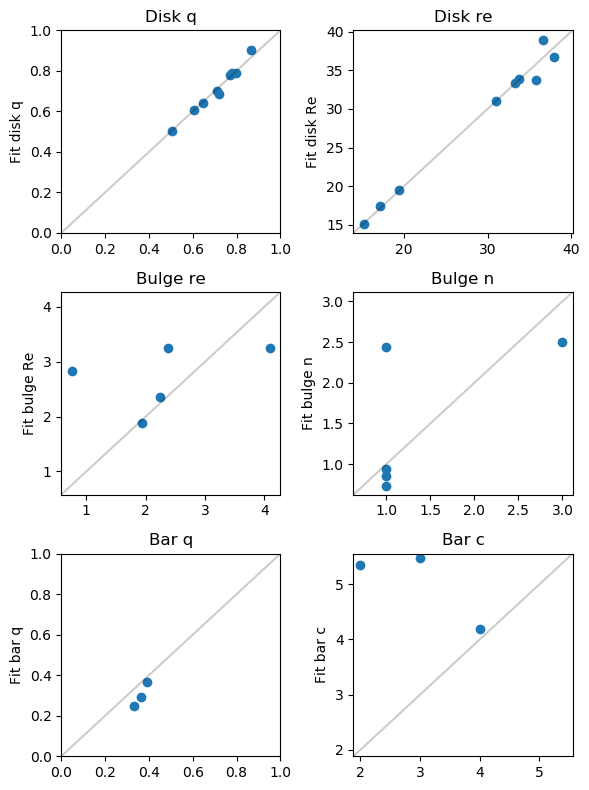

In [56]:
ks = [('disk', 'q'), ('disk', 'Re'), ('bulge', 'Re'), ('bulge', 'n'), ('bar', 'q'), ('bar', 'c')]
f, ax_ = plt.subplots(ncols=2, nrows=3, figsize=(6, 8), dpi=100)
ax = ax_.ravel()
for i in range(len(ks)):
    plt.sca(ax[i])
    k = ks[i]
    k2 = tuple([f'{j}_fit' for j in k])
    print(k)
    plt.scatter(fitting_df.loc[k], fitting_df.loc[k2])
    plt.title(' '.join(k).capitalize())
#     plt.xlabel(' '.join(k).capitalize())
    plt.ylabel('Fit ' + ' '.join(k))
    ax[i].add_line(plt.Line2D((0, 1E5), (0, 1E5), c='k', alpha=0.2))
    if 'q' in k:
        plt.xlim(0, 1)
        plt.ylim(0, 1)
    else:
        l = np.stack((plt.xlim(), plt.ylim()))
        plt.xlim(l.min(), l.max())
        plt.ylim(l.min(), l.max())
plt.tight_layout()

## Spiral pitch angle recovery

In [57]:
agg_pitch_angles = agg_results.apply(lambda a: pd.Series([b.pa * b.chirality for b in a.spiral_arms], dtype=float))
agg_pitch_angles.index = index_map.name[agg_pitch_angles.index]
agg_pitch_angles.columns = pd.MultiIndex.from_product([['spiral_agg'], [f'phi.{i}' for i in agg_pitch_angles.columns]])
agg_pitch_angles

spiral_agg                      
                             phi.0      phi.1      phi.2
name                                                    
disk_sp_model           -28.283550 -25.101069 -14.936064
disk_bulge_model2              NaN        NaN        NaN
disk_bar_sp_model        -9.739853  -8.938560        NaN
disk_bar_sp_model2       25.001978  21.397447        NaN
disk_bulge_model               NaN        NaN        NaN
disk_bulge_bar_sp_model  35.264582  19.618960        NaN
disk_bulge_bar_model           NaN        NaN        NaN
disk_model                     NaN        NaN        NaN
disk_bulge_sp_model      12.608113  13.633626        NaN

In [58]:
spiral_df = pd.concat((
    fitting_df.loc[[('spiral', f'phi.{i}') for i in range(3)]],
    fitting_df.loc[[('spiral_fit', f'phi.{i}_fit') for i in range(3)]],
    agg_pitch_angles.T
), axis=0)

agg_pa_err = pd.Series([], dtype=object)
fit_pa_err = pd.Series([], dtype=object)
for model in spiral_df.columns:
    base_spirals = spiral_df[model].xs('spiral').reset_index(drop=True).rename('phi_base')
    agg_spirals = spiral_df[model].xs('spiral_agg').reset_index(drop=True).rename('phi_agg')
    fit_spirals = spiral_df[model].xs('spiral_fit').reset_index(drop=True).rename('phi_fit')
    agg_idx = pd.MultiIndex.from_product([base_spirals.index, agg_spirals.index], names=['base', 'agg'])
    agg_pairs = pd.concat([
        base_spirals.reindex(agg_idx, level='base'),
        agg_spirals.reindex(agg_idx, level='agg')
    ], axis=1)
    fit_idx = pd.MultiIndex.from_product([base_spirals.index, fit_spirals.index], names=['base', 'fit'])
    fit_pairs = pd.concat([
        base_spirals.reindex(fit_idx, level='base'),
        fit_spirals.reindex(fit_idx, level='fit')
    ], axis=1)
    agg_pa_err.loc[model] = (agg_pairs.phi_base - agg_pairs.phi_agg).abs().dropna().min(level=0)    
    fit_pa_err.loc[model] = (fit_pairs.phi_base - fit_pairs.phi_fit).abs().dropna().min(level=0)

In [59]:
display(agg_pa_err.apply(pd.Series).T.unstack().dropna().sort_values().rename('aggregate'))
display(fit_pa_err.apply(pd.Series).T.unstack().dropna().sort_values().rename('fit'))

                         base
disk_bar_sp_model        1       0.104838
disk_bulge_bar_sp_model  0       0.381040
disk_bar_sp_model2       0       1.397447
disk_bulge_bar_sp_model  1       1.536476
disk_sp_model            2       3.545086
                         0       3.598100
disk_bar_sp_model2       1       3.781856
disk_sp_model            1       5.025559
disk_bar_sp_model        0       7.315314
disk_bulge_sp_model      0       8.532579
                         1       8.629923
Name: aggregate, dtype: float64

                         base
disk_bulge_bar_sp_model  1       0.082444
disk_bar_sp_model        1       0.254269
disk_bulge_sp_model      0       1.092665
                         1       1.190009
disk_sp_model            2       1.913233
disk_bulge_bar_sp_model  0       2.945404
disk_bar_sp_model        0       3.450311
disk_bar_sp_model2       0       3.518028
disk_sp_model            0       3.742464
                         1       5.283810
disk_bar_sp_model2       1       5.902436
Name: fit, dtype: float64